# LAB 5 MOS: Optimización Multiobjetivo

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

### Formulación del modelo Multiobjetivo

#### Conjuntos

$$ R = \{alimentos,agua,medicinas,equipo medico,mantas\}$$
$$ A = \{A_1,A_2,A_3,A_4\}$$
$$ Z = \{A,B,C,D\}$$
$$ V = \{V_1,V_2\} $$

#### Parámetros

Recursos:

Valor de impacto (miles USD/TON):
$$ Va_r: \forall r \in R $$

Peso(TON/unidad):
$$ W_r: \forall r \in R$$

Volumen(m^3/unidad):
$$ V_r: \forall r \in R$$

Disponibilidad(unidades):
$$ D_r: \forall r \in R$$

Aviones:

Capacidad Peso (TON):
$$ CP_a: \forall a \in A$$

Capacidad Volumen (m^3):
$$ CV_a: \forall a \in A$$

Costo Fijo (miles UDS):
$$ CF_a: \forall a \in A$$

Costo Variable (miles UDS/km):
$$ C_a: \forall a \in A$$

Zonas:

Distancias (km):
$$ D_z: \forall z \in Z$$

Poblacion (miles):
$$ P_z: \forall z \in Z$$

Multiplicador:
$$ M_z: \forall z \in Z$$

Necesidad de recurso por zona (TON):
$$ N _{r,z}: \forall r \in R, \forall z \in Z $$

#### Variables de decision

Asignación de aviones a zonas:

$$ x_{a,z,v} \in {0,1}, \forall a \in A, \forall z \in Z, \forall v \in V $$

Asignación de recursos a aviones en cada vuelo:

$$ y_{a,z,r,v} \in N, \forall a \in A, \forall z \in Z, \forall r \in R, \forall V \in V $$

Asignación de medicamentos en un vuelo de un avion:

$$ z_{a,z} \in {0,1}, \forall a \in A, \forall z \in Z $$

#### Funciones objetivo

Maximizar Impacto social:
$$ Z_1 = \sum_{r\in R} \sum_{a\in A} \sum_{v\in V} \sum_{z\in Z} Va_r \cdot y_{a,z,r,v} \cdot M_z $$

Minimizar Costo de tranporte:
$$ Z_2 = \sum_{a\in A} \sum_{z\in Z} \sum_{v\in V} CF_a \cdot x_{a,z,v} + \sum_{v\in V} \sum_{z\in Z} \sum_{a\in A} C_a \cdot x_{a,z,v} \cdot D_z $$


#### Restricciones

Capacidad de peso y volumen de los aviones:
$$ \sum_{r\in R} \sum_{z\in Z} y_{a,z,r,v} \cdot W_r \leq CP_a, \forall a \in A, \forall v \in V $$
$$ \sum_{r\in R} \sum_{z\in Z} y_{a,z,r,v} \cdot V_r \leq CV_a, \forall a \in A, \forall v \in V $$

Asignacion de recursos no sobrepase la disponibilidad:
$$ \sum_{a\in A} \sum_{v\in V} \sum_{z\in Z} y_{a,z,r,v} \leq D_r, \forall r \in R $$

Seguridad de los medicamentos:
$$ y_{1,z,medicamento,v} = 0, \forall v \in V, \forall z \in Z $$

Compatibilidad de recursos (no se puede llevar agua si se llevan medicamentos):
$$ \sum_{z \in Z} y_{a,z,agua,v} <=  (1 - z_{a,v}) \cdot BigM, \forall a \in A, \forall v \in V $$

$$ \sum_{z \in Z} y_{a,z,medicamentos,v} <=  z_{a,v} \cdot BigM, \forall a \in A, \forall v \in 
V $$

Asignacion de zonas por avion y viaje (el avion solo puede ir una vez a una zona):
$$ \sum_{z\in Z} \sum_{v\in V} x_{a,z,v} \leq 1, \forall a \in A $$

Satisfaccion de necesidades:
$$ \sum_{a\in A} \sum_{v\in V} y_{a,r,v} \geq D_z, \forall z \in Z, \forall r \in R $$

Solo lleva recursos si va a la zona:
$$ x_{a,z,v} \cdot BigM \geq  y_{az,,r,v}, \forall z \in Z, \forall v \in V, \forall a \in A, \forall r \in R $$

No negatividad y binaria:
$$ x_{a,z,v} \in {0,1} $$
$$ z_{a,v} \in {0,1} $$
$$ y_{a,r,v} \geq 0  \in N$$

#### Modelo de optimización

En este caso e-constraint es una tecnica adecuada para resolver este problema multiobjetivo. Permite maximizar el impacto social dejandolo como función objetivo y minimizar el costo de transporte mediante el constraint adicional variando el limite.

### Implementación del modelo

In [13]:
recursos = ['alimentos', 'agua', 'medicinas', 'equipo_medico', 'mantas'] 
aviones = ['A1', 'A2', 'A3', 'A4']  
zonas = ['A','B','C','D']
viajes = ['V1', 'V2']

datos_recursos = {
    'alimentos': {'valor': 50, 'peso': 5, 'volumen': 3, 'disponibilidad': 12}, #12
    'medicinas': {'valor': 100, 'peso': 2, 'volumen': 1, 'disponibilidad': 15}, #15
    'equipo_medico': {'valor': 120, 'peso': 0.3, 'volumen': 0.5, 'disponibilidad': 40}, #40
    'agua': {'valor': 60, 'peso': 6, 'volumen': 4, 'disponibilidad': 15}, #15
    'mantas': {'valor': 40, 'peso': 3, 'volumen': 2, 'disponibilidad': 20}, #20
}

datos_aviones = {
    'A1': {'peso_max': 40, 'volumen_max': 35, 'costo_fijo': 15, 'costo_variable': 0.020},
    'A2': {'peso_max': 50, 'volumen_max': 40, 'costo_fijo': 20, 'costo_variable': 0.025},
    'A3': {'peso_max': 60, 'volumen_max': 45, 'costo_fijo': 25, 'costo_variable': 0.030},
    'A4': {'peso_max': 45, 'volumen_max': 38, 'costo_fijo': 18, 'costo_variable': 0.022}
}

datos_zonas = {
    'A': {'distancia': 800, 'poblacion': 50, 'multiplicador': 1.2},
    'B': {'distancia': 1200, 'poblacion': 70, 'multiplicador': 1.5},
    'C': {'distancia': 1500, 'poblacion': 100, 'multiplicador': 1.8},
    'D': {'distancia': 900, 'poblacion': 80, 'multiplicador': 1.4}
}

# toneladas (es necesario tratarlas como unidades)
necesidades_minimas = {
    'A': {'alimentos': 8, 'agua': 6, 'medicinas': 2, 'equipo_medico': 0.6, 'mantas': 3},
    'B': {'alimentos': 12, 'agua': 9, 'medicinas': 3, 'equipo_medico': 0.9, 'mantas': 5},
    'C': {'alimentos': 16, 'agua': 12, 'medicinas': 4, 'equipo_medico': 1.2, 'mantas': 7},
    'D': {'alimentos': 10, 'agua': 8, 'medicinas': 2, 'equipo_medico': 0.6, 'mantas': 4}
}

In [14]:
from pyomo.environ import *
import numpy as np

# Crear un modelo
model = ConcreteModel()

# Conjuntos
model.R = Set(initialize=recursos)
model.A = Set(initialize=aviones)
model.Z = Set(initialize=zonas)
model.V = Set(initialize=viajes)

# Parámetros
model.Va = Param(model.R, initialize={r: datos_recursos[r]['valor'] for r in recursos})
model.W = Param(model.R, initialize={r: datos_recursos[r]['peso'] for r in recursos})
model.V_r = Param(model.R, initialize={r: datos_recursos[r]['volumen'] for r in recursos})
model.D_r = Param(model.R, initialize={r: datos_recursos[r]['disponibilidad'] for r in recursos})

model.CP = Param(model.A, initialize={a: datos_aviones[a]['peso_max'] for a in aviones})
model.CV = Param(model.A, initialize={a: datos_aviones[a]['volumen_max'] for a in aviones})
model.CF = Param(model.A, initialize={a: datos_aviones[a]['costo_fijo'] for a in aviones})
model.C = Param(model.A, initialize={a: datos_aviones[a]['costo_variable'] for a in aviones})

model.D_z = Param(model.Z, initialize={z: datos_zonas[z]['distancia'] for z in zonas})
model.M_z = Param(model.Z, initialize={z: datos_zonas[z]['multiplicador'] for z in zonas})
model.N = Param(model.Z, model.R, initialize={(z, r): necesidades_minimas[z][r] for z in zonas for r in recursos})

# Epsilon
model.epsilon = Param(mutable=True, initialize=1e6)

# Variables de decisión
model.x = Var(model.A, model.Z, model.V, within=Binary)  # Asignación de aviones a zonas por viaje
model.y = Var(model.A, model.Z, model.R, model.V, within=NonNegativeReals)  # Cantidad de recursos transportados por avión
model.z = Var(model.A, model.V, within=Binary)  # Determina si el avion a en el viaje v lleva medicamentos

# Función Objetivo 1: Maximizar impacto social

def impacto_social(model):
    return sum(model.Va[r] * model.y[a, z, r, v] * model.M_z[z]
               for a in model.A for z in model.Z for r in model.R for v in model.V)
model.obj = Objective(rule=impacto_social, sense=maximize)

# Función Objetivo 2: Minimizar costo de transporte (Como expresion)

def costo_transporte(model):
    return sum(model.CF[a] * model.x[a, z, v] 
               + model.C[a] * model.D_z[z] * model.x[a, z, v]
               for a in model.A for z in model.Z for v in model.V)
model.costo_total = Expression(rule=costo_transporte)

# e-constraint
model.epsilon_constraint = Constraint(expr=model.costo_total <= model.epsilon)

# --- Restricciones ---

# Restricción de capacidad de peso y volumen de los aviones

def restr_capacidad_peso(m, a, v):
    return sum(m.y[a, z, r, v] * m.W[r] 
               for z in m.Z for r in m.R) <= m.CP[a]
model.restr_capacidad_peso = Constraint(model.A, model.V, rule=restr_capacidad_peso)

def restr_capacidad_volumen(m, a, v):
    return sum(m.y[a, z, r, v] * m.V_r[r] 
               for z in m.Z for r in m.R) <= m.CV[a]
model.restr_capacidad_volumen = Constraint(model.A, model.V, rule=restr_capacidad_volumen)

# Restricción de disponibilidad de los recursos TODO
#def restriccion_disponibilidad(model, r):
    #return sum(model.y[a, r, v] for a in model.A for v in model.V) <= model.D_r[r]
#model.restriccion_disponibilidad = Constraint(model.R, rule=restriccion_disponibilidad)

def restr_disponibilidad(m, r):
    return sum(m.y[a, z, r, v] for a in m.A for z in m.Z for v in m.V) <= m.D_r[r]
model.restr_disponibilidad = Constraint(model.R, rule=restr_disponibilidad)

# Restricción de seguridad de los medicamentos (medicinas no se pueden transportar en el avión A1)
def restriccion_medicinas(model, v, z):
    return model.y['A1', z,'medicinas', v] == 0
model.restriccion_medicinas = Constraint(model.V, model.Z,rule=restriccion_medicinas)

M = 1e5
# Si transporta agua, no puede transportar medicinas
def restriccion_agua_z(model, a, v):
    return sum(model.y[a, z,'agua', v] for z in model.Z) <= (1 - model.z[a, v]) * M
model.restriccion_agua_z = Constraint(model.A, model.V, rule=restriccion_agua_z)

# Si transporta medicinas, no puede transportar agua
def restriccion_medicinas_z(model, a, v):
    return sum(model.y[a,z , 'medicinas', v] for z in model.Z) <= model.z[a, v] * M
model.restriccion_medicinas_z = Constraint(model.A, model.V, rule=restriccion_medicinas_z)

# Restricción de asignación de zona unica por vuelo
def restriccion_zona_unica(model, a, v):
    return sum(model.x[a, z, v] for z in model.Z) <= 1
model.restriccion_zona_unica = Constraint(model.A, model.V,rule=restriccion_zona_unica)

# Restricción de no repetir zona
def restriccion_zona_viaje(model, a, z):
    return model.x[a, z, 'V1'] + model.x[a, z, 'V2'] <= 1
model.restriccion_zona_viaje = Constraint(model.A, model.Z,rule=restriccion_zona_viaje)

# Restricción de satisfacción de las necesidades mínimas TODO

def restr_necesidades(m, z, r):
    return sum(m.y[a, z, r, v] * m.W[r] for a in m.A for v in m.V) >= m.N[z, r]
model.restr_necesidades = Constraint(model.Z, model.R, rule=restr_necesidades)

# Restricción de transporte solo si el avión va a la zona (vinculo x-y)
def vinculo_y_x(m, a, z, r, v):
    return m.y[a, z, r, v] <= M * m.x[a, z, v]
model.vinculo_y_x = Constraint(model.A, model.Z, model.R, model.V, rule=vinculo_y_x)



In [15]:
# Correr el modelo para diferentes valores de epsilon
import matplotlib.pyplot as plt
from tabulate import tabulate

solver = SolverFactory('glpk')

def mostrar_viajes(m, epsilon, impacto, costo):
    print(f"\n============ Solución para ε = {epsilon:.2f} ============")
    print(f"Impacto Social: {impacto:.2f}")
    print(f"Costo Total: {costo:.2f}\n")

    # Acumulador para recursos enviados por zona
    recursos_por_zona = {z: {r: 0 for r in recursos} for z in zonas}

    for a in m.A:
        for z in m.Z:
            for v in m.V:
                if m.x[a, z, v].value > 0.5:
                    recursos_viaje = []
                    peso_total = 0
                    volumen_total = 0
                    for r in m.R:
                        qty = m.y[a, z, r, v].value
                        if qty > 0.5:
                            recursos_viaje.append([r, qty])
                            # Sumar para tonelaje y volumen
                            peso_total += qty * datos_recursos[r]['peso']  # peso en toneladas
                            volumen_total += qty * datos_recursos[r]['volumen']
                            # Acumular para el resumen final
                            recursos_por_zona[z][r] += qty

                    if recursos_viaje:
                        print(f"🚀 En el viaje {v} del avión {a} hacia la zona {z}, se lleva:")
                        print(tabulate(recursos_viaje, headers=["Recurso", "Unidades"], tablefmt="fancy_grid", floatfmt=".1f"))
                        print(f"⚖️  Peso total: {peso_total:.2f} toneladas")
                        print(f"📦 Volumen total: {volumen_total:.2f} m³")
                        print("\n" + "-"*60 + "\n")

    # Mostrar resumen total por zona
    print("\n========= Resumen total enviado a cada zona =========\n")
    for z in zonas:
        resumen_zona = []
        for r in recursos:
            qty_total = recursos_por_zona[z][r]
            if qty_total > 0.5:  # Mostrar solo si se envió algo
                resumen_zona.append([r, qty_total * datos_recursos[r]['peso']])
        if resumen_zona:
            print(f"🏝️ Zona {z}:")
            print(tabulate(resumen_zona, headers=["Recurso", "Toneladas"], tablefmt="fancy_grid", floatfmt=".1f"))
            print("\n")


# Primero obtenemos el costo mínimo (ideal)

model.obj.deactivate()
model_min = Objective(expr=model.costo_total, sense=minimize)
model.add_component('min_obj', model_min)
res1 = solver.solve(model)
costo_min = model.costo_total()
print("Limite inferior de e encontrado")

# Y el costo máximo permitiendo máximo impacto social
model.del_component('min_obj')
model.obj.activate()
res2 = solver.solve(model)
costo_max = model.costo_total()
print("Limite superior de e encontrado")

# Definimos valores de epsilon (entre el mínimo y el máximo)
epsilons = np.linspace(costo_min, costo_max, 7)

# Guardamos resultados
impactos = []
costos = []
print("Iniciando a hallar los valores para el frente")
for eps in epsilons:
    model.epsilon = eps
    resultado = solver.solve(model)
    impacto = model.obj()
    costo = model.costo_total()
    if (impacto_social(model)() > 0):
        mostrar_viajes(model, eps, impacto, costo)
    impactos.append(impacto)
    costos.append(costo)


Limite inferior de e encontrado
Limite superior de e encontrado
Iniciando a hallar los valores para el frente

============ Solución para ε = 362.90 ============
Impacto Social: 14362.27
Costo Total: 362.90

🚀 En el viaje V2 del avión A1 hacia la zona B, se lleva:
╒═══════════════╤════════════╕
│ Recurso       │   Unidades │
╞═══════════════╪════════════╡
│ agua          │        4.4 │
├───────────────┼────────────┤
│ equipo_medico │        3.0 │
├───────────────┼────────────┤
│ mantas        │        4.3 │
╘═══════════════╧════════════╛
⚖️  Peso total: 40.00 toneladas
📦 Volumen total: 27.57 m³

------------------------------------------------------------

🚀 En el viaje V1 del avión A1 hacia la zona C, se lleva:
╒═══════════════╤════════════╕
│ Recurso       │   Unidades │
╞═══════════════╪════════════╡
│ alimentos     │        3.2 │
├───────────────┼────────────┤
│ agua          │        2.0 │
├───────────────┼────────────┤
│ equipo_medico │       31.3 │
├───────────────┼────────────┤

#### Visualizacion del frente de Pareto

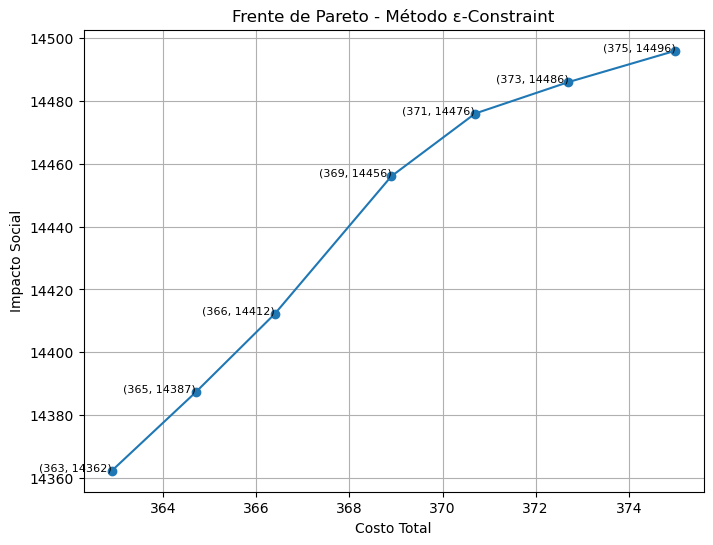

In [16]:
# Graficamos el frente de Pareto con etiquetas en los puntos
plt.figure(figsize=(8,6))
plt.plot(costos, impactos, marker='o')

for i in range(len(costos)):
    plt.text(costos[i], impactos[i], f"({costos[i]:.0f}, {impactos[i]:.0f})", fontsize=8, ha='right')

plt.xlabel('Costo Total')
plt.ylabel('Impacto Social')
plt.title('Frente de Pareto - Método ε-Constraint')
plt.grid(True)
plt.show()

### Analisis

Dado que todas las soluciones del frente de Pareto cumplen con las necesidades mínimas establecidas en las restricciones, la opción correspondiente a ε = 362.90 puede considerarse una solución válida y aceptable. Sin embargo, resulta especialmente interesante analizar también la solución asociada a ε = 368.95, ya que es la que presenta la mayor pendiente en el frente de Pareto. Esto significa que, en ese punto, el impacto social crece de forma más significativa en relación con el incremento del coste. En otras palabras, es el tramo donde se obtiene la mayor mejora relativa en impacto por cada unidad adicional de coste, lo cual puede interpretarse como un uso muy eficiente de los recursos adicionales.

Por otro lado, al analizar la sensibilidad del modelo frente a cambios en los coeficientes de impacto asignados a cada zona, se observa que la distribución óptima se adapta para priorizar las zonas que incrementan su peso relativo. Por ejemplo, si se aumenta el multiplicador de importancia de la zona C —la cual ya cuenta con la mayor población y el multiplicador más alto—, el modelo tiende a destinar aún más recursos a esa zona. De hecho, en todas las soluciones analizadas, la zona C recibe sistemáticamente un excedente de recursos, es decir, cantidades superiores a las necesidades mínimas establecidas, mientras que en otras zonas, algunos recursos apenas cubren el nivel mínimo requerido. Esto refleja que el modelo responde de forma coherente a los cambios de prioridad y que la asignación tiende naturalmente a favorecer las zonas con mayor impacto esperado, ajustando el transporte para maximizar el beneficio social total.

Se tomo a y como real por motivos de rendimiento. El modelo de esta manera es capaz de resolverse en pocos minutos, mientras que al correrlo como entero tomaba demasiado tiempo. Una opcion viable es para los casos en que de unidades no enteras, se aproxime al entero positivo mas alto (si es posible) o mas bajo (si las resstricciones no lo permiten)

## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

### Formulación del modelo Multiobjetivo

#### Conjuntos
* $N$ conjunto de ciudades incluyendo el nodo 0

* $M$ Conjunto de equipos disponibles para realizar la ruta
* $A$ Arcos

#### Parámetros
* $c_{i,j,k}$ costo de recorrer de $i$ a $j$
* $q_{i}$ calidad de recorrer de $i$
* $r_{i,j}$ riesgo de recorrer de $i$ a $j$

#### Variables de decision
* $x_{i,j} \in  {0,1}$
* $ u_{i,k} \in \mathbb{R}^+$ : Variable auxiliar para eliminar subciclos.

#### Funciones objetivo
1. minimizar distancia total recorrida
$$Z_1= \sum_{k \in M}\sum_{i \in A}\sum_{j \in A} c_{i,j,k} \times x_{i,j} $$
2. mazimizar la calidad
$$Z_2= \sum_{k \in M}\sum_{i \in A | i \neq 0}\sum_{j \in A}q_{i} \times x_{i,j} $$
3. minimizar el riesgo
$$Z_3= \sum_{k \in M}\sum_{i \in A}\sum_{j \in A} r_{i,j}\times x_{i,j}$$


#### Restricciones
1. **Salida única de cada ciudad** (excepto el nodo 0):

$$
\sum_{j \in N, j \neq i} \sum_{k \in M} x_{ijk} = 1, \quad \forall i \in N, i \neq 0
$$

2. **Inicio desde el nodo 0 para cada equipo**:

$$
\sum_{j \in N, j \neq 0} x_{0jk} = 1, \quad \forall k \in M
$$

3. **Retorno al nodo 0 para cada equipo**:

$$
\sum_{i \in N, i \neq 0} x_{i0k} = 1, \quad \forall k \in M
$$



4. **Flujo de continuidad entre ciudades (entrada = salida)**:

$$
\sum_{j \in N, j \neq i} x_{ijk} = \sum_{j \in N, j \neq i} x_{jik}, \quad \forall i \in N, i \neq 0, \forall k \in M
$$



5. **Eliminación de subciclos (restricción MTZ)**:

$$
u_{ik} - u_{jk} + (|N| - 1)x_{ijk} \leq |N| - 2, \quad \forall i, j \in N, i \neq j, i, j \neq 0, \forall k \in M
$$


6. **Prohibición de autoasignación (no auto-bucles)**:

$$
x_{iik} = 0, \quad \forall i \in N, \forall k \in M
$$


### Modelo de optimización
Para resolver el modelo propuesto, se emplea el método de suma ponderada normalizada, el cual permite combinar múltiples funciones objetivo en una sola expresión agregada. Este enfoque es especialmente útil cuando se desean considerar simultáneamente distintos criterios, como la distancia recorrida, la calidad de las rutas y el riesgo asociado. Una de sus principales ventajas es su facilidad de implementación e interpretación, lo que lo hace ampliamente utilizado en problemas prácticos de optimización. Además, al variar los pesos asignados a cada objetivo, el método permite explorar distintas soluciones comprometidas (trade-offs), proporcionando una mayor flexibilidad en la toma de decisiones. Dado que las funciones objetivo pueden tener escalas diferentes, es necesario normalizar sus valores antes de combinarlos, para evitar que un criterio domine a los demás de forma desproporcionada.


### Implementación del modelo




Para este caso, cada función objetivo es transformada para que este entre 0 y 1

$$norm(Z)= \frac{z-z_{min}}{z_{max}-z_{min}}$$

In [2]:
class RoutingPlannerMOP:
    def __init__(self, matriz_costos, niveles_calidad, niveles_riesgo, num_equipos):
        self.matriz_costos = matriz_costos
        self.niveles_calidad = niveles_calidad
        self.niveles_riesgo = niveles_riesgo
        self.num_ciudades = len(matriz_costos)
        self.num_equipos = num_equipos

    def construir_modelo(self):
        m = ConcreteModel()
        m.CIUDADES = RangeSet(0, self.num_ciudades - 1)
        m.EQUIPOS = RangeSet(1, self.num_equipos)

        arcos = [(i, j) for i in m.CIUDADES for j in m.CIUDADES if i != j]
        m.ARCOS = Set(initialize=arcos, dimen=2)

        m.ruta_asignada = Var(m.ARCOS, m.EQUIPOS, domain=Binary)
        m.orden_visita = Var(m.CIUDADES, m.EQUIPOS, domain=NonNegativeReals, bounds=(1, self.num_ciudades - 1))

        m.distancia_total = Expression(expr=sum(self.matriz_costos[i][j] * m.ruta_asignada[i, j, k] for (i, j) in m.ARCOS for k in m.EQUIPOS))
        m.calidad_total = Expression(expr=sum(self.niveles_calidad[i] * m.ruta_asignada[i, j, k] for (i, j) in m.ARCOS for k in m.EQUIPOS if i != 0))
        m.riesgo_total = Expression(expr=sum(self.niveles_riesgo[(i, j)] * m.ruta_asignada[i, j, k] for (i, j) in m.ARCOS for k in m.EQUIPOS))

        m.salida_unica = Constraint(m.CIUDADES, rule=self.restriccion_salida)
        m.inicio_equipo = Constraint(m.EQUIPOS, rule=self.restriccion_inicio)
        m.fin_equipo = Constraint(m.EQUIPOS, rule=self.restriccion_retorno)
        m.flujo = Constraint(m.CIUDADES, m.EQUIPOS, rule=self.restriccion_flujo)
        m.antiloop = Constraint(m.CIUDADES, m.CIUDADES, m.EQUIPOS, rule=self.restriccion_mtz)
        m.no_autoruta = Constraint(m.CIUDADES, m.EQUIPOS, rule=self.restriccion_no_autobucles)

        self.modelo = m

    def restriccion_salida(self, m, i):
        if i != 0:
            return sum(m.ruta_asignada[i, j, k] for j in m.CIUDADES for k in m.EQUIPOS if i != j) == 1
        return Constraint.Skip

    def restriccion_inicio(self, m, k):
        return sum(m.ruta_asignada[0, j, k] for j in m.CIUDADES if j != 0) == 1

    def restriccion_retorno(self, m, k):
        return sum(m.ruta_asignada[i, 0, k] for i in m.CIUDADES if i != 0) == 1

    def restriccion_flujo(self, m, i, k):
        if i != 0:
            return sum(m.ruta_asignada[i, j, k] for j in m.CIUDADES if i != j) == sum(m.ruta_asignada[j, i, k] for j in m.CIUDADES if i != j)
        return Constraint.Skip

    def restriccion_mtz(self, m, i, j, k):
        if i != 0 and j != 0 and i != j:
            return m.orden_visita[i, k] - m.orden_visita[j, k] + (self.num_ciudades - 1) * m.ruta_asignada[i, j, k] <= self.num_ciudades - 2
        return Constraint.Skip

    def restriccion_no_autobucles(self, m, i, k):
        if (i, i) in m.ARCOS:
            return m.ruta_asignada[i, i, k] == 0
        return Constraint.Skip

    def resolver_suma_ponderada(self, w1, w2, w3, Z1_min, Z1_max, Z2_min, Z2_max, Z3_min, Z3_max):
        self.construir_modelo()
        m = self.modelo

        def normalizar(expr, minimo, maximo):
            if maximo - minimo == 0:
                return expr
            return (expr - minimo) / (maximo - minimo)

        Z1_norm = normalizar(m.distancia_total, Z1_min, Z1_max)
        Z2_norm = normalizar(m.calidad_total, Z2_min, Z2_max)
        Z3_norm = normalizar(m.riesgo_total, Z3_min, Z3_max)

        m.objetivo_agregado = Objective(expr=w1 * Z1_norm - w2 * Z2_norm + w3 * Z3_norm, sense=minimize)

        SolverFactory('glpk').solve(m)

        return value(m.distancia_total), value(m.calidad_total), value(m.riesgo_total)


In [3]:
import csv
import numpy as np
from pyomo.environ import *

def cargar_matriz_costos(archivo_csv):
    with open(archivo_csv, 'r', newline='') as archivo:
        lector = csv.reader(archivo)
        next(lector)  # Omitir encabezado
        filas = list(lector)

    matriz = np.array(filas, dtype=int)
    for fila in range(matriz.shape[0]):
        for columna in range(matriz.shape[1]):
            if matriz[fila, columna] == 0 and fila != columna:
                matriz[fila, columna] = 999
    return matriz

# Definir niveles de riesgo entre localidades
total_localidades = 10
matriz_riesgos = {}
riesgos_definidos = {
    (0,1): 3, (0,2): 2, (0,3): 4, (0,4): 5, (0,5): 6, (0,6): 3, (0,7): 2, (0,8): 4, (0,9): 5,
    (2,8): 9, (2,9): 8, (3,4): 5, (4,9): 7, (5,6): 7, (8,9): 7
}
for origen in range(total_localidades):
    for destino in range(total_localidades):
        if origen == destino:
            matriz_riesgos[(origen, destino)] = 0
        else:
            matriz_riesgos[(origen, destino)] = riesgos_definidos.get((origen, destino), 5)

print("Mapa de riesgo por rutas:")
print(matriz_riesgos)

matriz_costos = cargar_matriz_costos('cost_matrix_10_nodes_1.5_spread.csv')
vector_calidad = [0, 95, 78, 75, 98, 83, 82, 82, 79, 98]
cantidad_equipos = 2

planificador = RoutingPlannerMOP(matriz_costos, vector_calidad, matriz_riesgos, cantidad_equipos)

def obtener_valor_extremo(indice_objetivo, sentido_optimizacion):
    planificador.construir_modelo()
    modelo = planificador.modelo
    if indice_objetivo == 1:
        modelo.funcion_objetivo = Objective(expr=modelo.distancia_total, sense=sentido_optimizacion)
    elif indice_objetivo == 2:
        modelo.funcion_objetivo = Objective(expr=-modelo.calidad_total, sense=sentido_optimizacion)
    else:
        modelo.funcion_objetivo = Objective(expr=modelo.riesgo_total, sense=sentido_optimizacion)

    solucionador = SolverFactory('glpk')
    solucionador.solve(modelo)
    return value(modelo.funcion_objetivo)

# Calcular mínimos y máximos por criterio
distancia_min = obtener_valor_extremo(1, minimize)
distancia_max = obtener_valor_extremo(1, maximize)
calidad_min = obtener_valor_extremo(2, minimize)
calidad_max = obtener_valor_extremo(2, maximize)
riesgo_min = obtener_valor_extremo(3, minimize)
riesgo_max = obtener_valor_extremo(3, maximize)

print(f"Valores extremos encontrados:\nDistancia: [{distancia_min}, {distancia_max}], "
      f"Calidad: [{calidad_min}, {calidad_max}], Riesgo: [{riesgo_min}, {riesgo_max}]")

combinaciones_pesos = [
    (0.7, 0.2, 0.1),
    (0.5, 0.3, 0.2),
    (0.3, 0.4, 0.3),
    (0.1, 0.7, 0.2),
    (0.2, 0.2, 0.6),
    (0.4, 0.4, 0.2),
    (0.33, 0.33, 0.34)
]

conjunto_resultados = []
for peso1, peso2, peso3 in combinaciones_pesos:
    z_distancia, z_calidad, z_riesgo = planificador.resolver_suma_ponderada(
        peso1, peso2, peso3,
        distancia_min, distancia_max,
        calidad_min, calidad_max,
        riesgo_min, riesgo_max
    )
    conjunto_resultados.append((peso1, peso2, peso3, z_distancia, z_calidad, z_riesgo))
    print(f"Pesos ({peso1:.2f}, {peso2:.2f}, {peso3:.2f}) -> "
          f"Distancia={z_distancia:.2f}, Calidad={z_calidad:.2f}, Riesgo={z_riesgo:.2f}")


Mapa de riesgo por rutas:
{(0, 0): 0, (0, 1): 3, (0, 2): 2, (0, 3): 4, (0, 4): 5, (0, 5): 6, (0, 6): 3, (0, 7): 2, (0, 8): 4, (0, 9): 5, (1, 0): 5, (1, 1): 0, (1, 2): 5, (1, 3): 5, (1, 4): 5, (1, 5): 5, (1, 6): 5, (1, 7): 5, (1, 8): 5, (1, 9): 5, (2, 0): 5, (2, 1): 5, (2, 2): 0, (2, 3): 5, (2, 4): 5, (2, 5): 5, (2, 6): 5, (2, 7): 5, (2, 8): 9, (2, 9): 8, (3, 0): 5, (3, 1): 5, (3, 2): 5, (3, 3): 0, (3, 4): 5, (3, 5): 5, (3, 6): 5, (3, 7): 5, (3, 8): 5, (3, 9): 5, (4, 0): 5, (4, 1): 5, (4, 2): 5, (4, 3): 5, (4, 4): 0, (4, 5): 5, (4, 6): 5, (4, 7): 5, (4, 8): 5, (4, 9): 7, (5, 0): 5, (5, 1): 5, (5, 2): 5, (5, 3): 5, (5, 4): 5, (5, 5): 0, (5, 6): 7, (5, 7): 5, (5, 8): 5, (5, 9): 5, (6, 0): 5, (6, 1): 5, (6, 2): 5, (6, 3): 5, (6, 4): 5, (6, 5): 5, (6, 6): 0, (6, 7): 5, (6, 8): 5, (6, 9): 5, (7, 0): 5, (7, 1): 5, (7, 2): 5, (7, 3): 5, (7, 4): 5, (7, 5): 5, (7, 6): 5, (7, 7): 0, (7, 8): 5, (7, 9): 5, (8, 0): 5, (8, 1): 5, (8, 2): 5, (8, 3): 5, (8, 4): 5, (8, 5): 5, (8, 6): 5, (8, 7): 5, (8, 8

#### Visulizacion del frente de Pareto

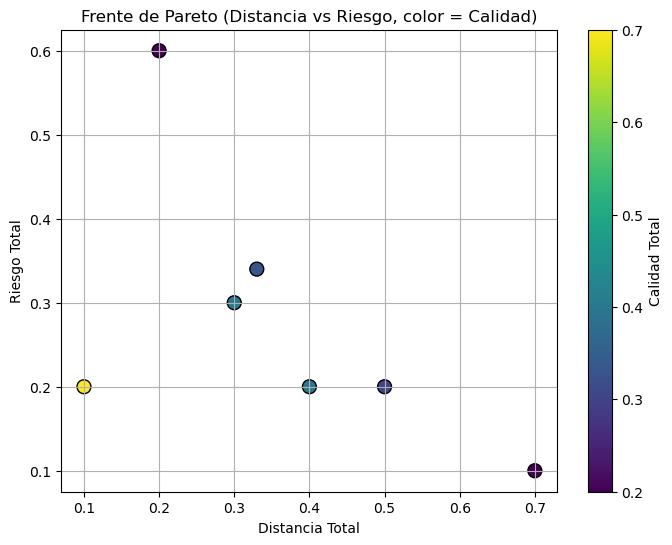

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extraer resultados
distancias = [r[0] for r in conjunto_resultados]
calidades = [r[1] for r in conjunto_resultados]
riesgos = [r[2] for r in conjunto_resultados]

plt.figure(figsize=(8, 6))
sc = plt.scatter(distancias, riesgos, c=calidades, cmap='viridis', s=100, edgecolors='k')
plt.colorbar(sc, label='Calidad Total')
plt.xlabel('Distancia Total')
plt.ylabel('Riesgo Total')
plt.title('Frente de Pareto (Distancia vs Riesgo, color = Calidad)')
plt.grid(True)
plt.show()


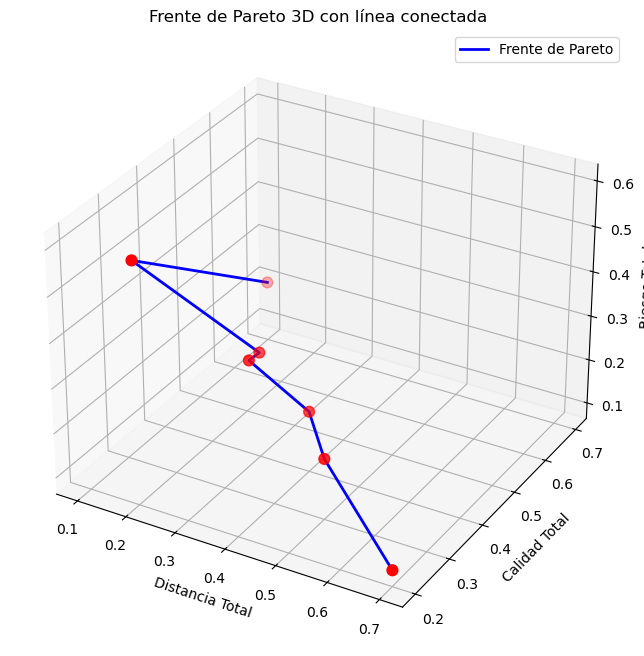

In [9]:
puntos_ordenados = sorted(zip(distancias, calidades, riesgos), key=lambda x: x[0])
x, y, z = zip(*puntos_ordenados)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, color='blue', linewidth=2, label='Frente de Pareto')

ax.scatter(x, y, z, color='red', s=60)

ax.set_xlabel('Distancia Total')
ax.set_ylabel('Calidad Total')
ax.set_zlabel('Riesgo Total')
ax.set_title('Frente de Pareto 3D con línea conectada')
ax.legend()
plt.show()

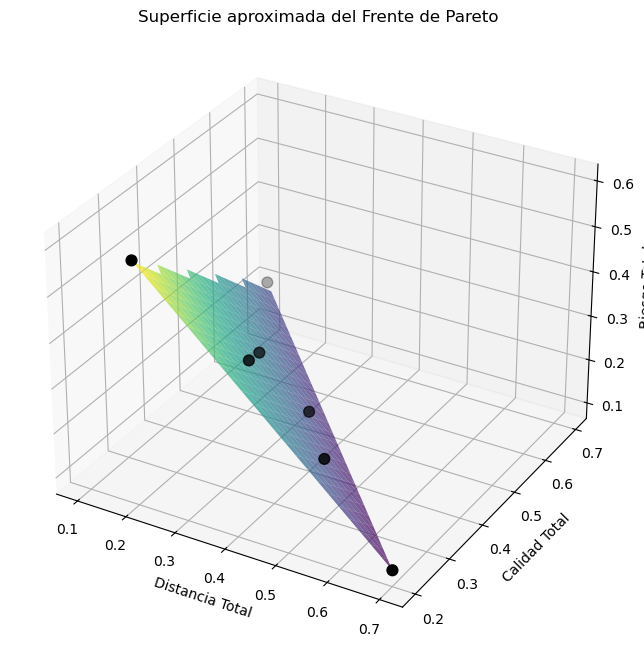

In [10]:
from scipy.interpolate import griddata

x = np.array(distancias)
y = np.array(calidades)
z = np.array(riesgos)

xi = np.linspace(x.min(), x.max(), 30)
yi = np.linspace(y.min(), y.max(), 30)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis', alpha=0.7)
ax.scatter(x, y, z, color='black', s=60)

ax.set_xlabel('Distancia Total')
ax.set_ylabel('Calidad Total')
ax.set_zlabel('Riesgo Total')
ax.set_title('Superficie aproximada del Frente de Pareto')
plt.show()


### Analisis

Se formuló un modelo de optimización multiobjetivo para la planificación de rutas entre ciudades, considerando tres criterios: minimizar la distancia total recorrida, maximizar la calidad del recorrido y minimizar el riesgo asociado a las rutas. Utilizando una suma ponderada normalizada, se evaluaron diferentes combinaciones de pesos para explorar el frente de Pareto. Sin embargo, los resultados mostraron una solución única y dominante para todos los escenarios: una distancia total de 20.0, una calidad máxima de 770.0 y un riesgo total de 49.0. Esto sugiere que el modelo está fuertemente dirigido hacia una única solución eficiente, posiblemente debido a la configuración de los datos o a las restricciones impuestas.

Las visualizaciones generadas —en 2D, 3D con líneas y superficie— confirmaron esta falta de diversidad en el frente de soluciones, mostrando puntos repetidos o planos homogéneos. Aunque el resultado refleja una alta robustez de la solución encontrada, también limita la capacidad de análisis multiobjetivo. Se recomienda revisar las restricciones del modelo y considerar enfoques más exploratorios, como algoritmos evolutivos (NSGA-II, SPEA2), que permitan identificar un conjunto más amplio de soluciones eficientes y con mayor variabilidad en los criterios evaluados.